In [1]:
import pandas as pd
df = pd.read_csv("../wargame-data/data/510064564/final_data.csv", index_col=0)
df.head()

/home/alex/miniconda3/envs/wargame-analysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,12,79,80,92,112,115,119,120,132,152,155,285,286,300,320,323,327,328,342,362,365,369,370,384,404,407,411,412,424,444,447,451,452,466,486,489,493,494,506,526,529) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AirplaneMinimalAltitude,Amphibious,ArmorFront,ArmorFrontSplashResistant,ArmorRear,ArmorRearSplashResistant,ArmorSides,ArmorSidesSplashResistant,ArmorTop,ArmorTopSplashResistant,...,Weapon9RangeShipMinimum,Weapon9RayonPinned,Weapon9ShotsPerSalvo,Weapon9SupplyCost,Weapon9Tags,Weapon9TimeBetweenSalvos,Weapon9TimeBetweenShots,Weapon9Type,Transporters,Decks
0,NaN,False,2,False,1,False,1,False,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18064,Motorized|Support
1,NaN,False,1,False,1,False,1,False,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mechanized|Armored|Support
2,NaN,False,2,False,1,False,1,False,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mechanized|Armored|Support
3,NaN,False,2,False,1,False,1,False,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mechanized|Armored|Support
4,NaN,True,2,False,1,False,1,False,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mechanized|Motorized|Armored


## Initial approach

The base `DataFrame` contains a lot of information, much of which is specific to a particular unit class. It makes the most sense to examine the attributes and sub-attributes of specific weapon classes. Tanks the simplest unit conceptually, so we'll study them first.

Selecting the attributes of the unit card that are relevant to the tank type is easy. Weapons are a bit harder. Obviously the weapon is just as important as the armor when it comes to deciding how to price a tank. But there are a lot of them, all having different types. For example, napalm bombs are very different from cluster bombs, which are very different from a tank cannon. And so on.

Instead of trying to build this complexity into our model by modeling things like weapon category, range, ammo count, and so on, we'll take a shortcut: just consider the weapons as static elements. A unit either has a weapon or it doesn't, and if it does have that weapon the "price" of that weapon gets tacked on to the price of the unit overall.

A difficulty with this approach is that weapons can appear in any position on a unit card, technically. For example, the same machine gun might be mounted in card position three on an ATGM tank, and in card position two on a non-ATGM tank. If we naively dummy encode weapon names, we will get duplicate columns. You can check where and when this occurs with the following code:

```python

pd.concat([pd.get_dummies(tanks[c]) for c in ['Weapon1Name', 'Weapon2Name', 'Weapon3Name']], 
           axis='columns', 
           verify_integrity=True
          )
```

So we have to do a little bit of work to treat those weapons differently (running a row-wise aggregator instead of a column-wise dummy ufunc). That, implemented as `merge_weapon_list`, follows below.

In [38]:
tanks = df.query("Tab == 'TNK'")

In [119]:
tanks = df.query("Tab == 'TNK'")

def merge_weapon_list(subframe, weapons):
    subsrs = []
    for w in weapons:
        subsrs.append(subframe.apply(lambda row: int((row == w).any()), axis='columns').rename(w))
    return pd.concat(subsrs, axis='columns')

multiple_position_weapons = ['DShK', 'HS.820', 'M2 Browning', 'MAG 7', 'Mk19', 'NF-1', 'NSVT', 'T54']

weapons = (pd.concat([pd.get_dummies(tanks[c]) for c in ['Weapon1Name', 'Weapon2Name', 'Weapon3Name']], 
           axis='columns')
     .pipe(lambda df: df.loc[:, [c for c in df if c not in multiple_position_weapons]])
     .join(merge_weapon_list(tanks[['Weapon1Name', 'Weapon2Name', 'Weapon3Name']], multiple_position_weapons),
          )
)

tanks_cols = [
    'Amphibious', 'ArmorFront', 'ArmorRear', 'ArmorSides', 'ArmorTop', 'Autonomy', 'MaxSpeed', 'Price', 'Year'
]
tanks = tanks.loc[:, tanks_cols].join(weapons).assign(NumWeapons=weapons.sum(axis=1))

In [120]:
tanks.head()

,Amphibious,ArmorFront,ArmorRear,ArmorSides,ArmorTop,Autonomy,MaxSpeed,Price,Year,2A20,...,Strela-2M,DShK,HS.820,M2 Browning,MAG 7,Mk19,NF-1,NSVT,T54,NumWeapons
30,False,3,1,2,1,400.0,60.0,35.0,1975.0,0,...,0,0,0,0,1,0,0,0,0,2
37,False,4,1,3,1,900.0,85.0,40.0,1991.0,0,...,0,0,0,0,0,0,1,0,0,2
40,False,3,1,2,1,400.0,60.0,25.0,1974.0,0,...,0,0,0,0,0,0,1,0,0,3
41,False,6,2,3,1,600.0,60.0,30.0,1967.0,0,...,0,0,0,0,0,0,1,0,0,2
42,False,7,2,4,2,600.0,70.0,40.0,1982.0,0,...,0,0,0,0,0,0,1,0,0,3


In [122]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import numpy as np

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(tanks)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

model = grid.best_estimator_

best bandwidth: 1.8329807108324356


In [123]:
model

KernelDensity(algorithm='auto', atol=0, bandwidth=1.8329807108324356,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

In [203]:
def draw_sample(model, n_nonweapon_vars):
    while True:
        # Get the draw.
        draw = pd.Series(model.sample(1)[0], tanks.columns)

        # Get the weapons.
        numweapons = draw.iloc[-1]
        weapons = draw.iloc[n_nonweapon_vars + 1:-1]
        weapons = weapons.sort_values(ascending=False).head(int(numweapons)).index

        # Establish the result.
        result = pd.concat([draw.iloc[:n_nonweapon_vars], 
                            pd.Series({'Weapon{0}Name'.format(i + 1): w for i, w in enumerate(weapons)})])

        # Clean up result values.
        result['Amphibious'] = result['Amphibious'] > 0.5
        for c in ['ArmorFront', 'ArmorRear', 'ArmorSides', 'ArmorTop']:
            result[c] = int(result[c])
        result['Autonomy'] = np.round(result['Autonomy'], -1)
        result['MaxSpeed'] = np.round(result['MaxSpeed'], -1)
        result['Price'] = np.round(result['Price'], -1)
        result['Year'] = np.round(result['Year'], 0)
        
        if (len(result) > 9) and (len(result) < 13):
            return result

In [226]:
draw_sample(model, 9)

Amphibious     False
ArmorFront         8
ArmorRear         -1
ArmorSides         5
ArmorTop           1
Autonomy         500
MaxSpeed          60
Price             40
Year            1973
Weapon1Name    XM-35
dtype: object

Hmm. Unfortunately there's no way to tell the kernel density estimator that we need strictly between 1 and 3 weapons, and that the weapon types have to be X, Y, Z (main cannon, perhaps a missile, and an MG), so an approach based on more specific and focused feature parameterization is the way to go.

## Another approach

This time around, let's try featurizing the data. Again, I do so on a per-type basis, as the features that matter for a tank are different from those which matter for infantry, which differ from those that matter for planes, and so on.

I will try this out on tanks first, re-using some of the code from the previous attempt.

In [7]:
tanks = df.query("Tab == 'TNK'")
obvious_cols = [
    'Amphibious', 'ArmorFront', 'ArmorRear', 'ArmorSides', 'ArmorTop', 'Autonomy', 'MaxSpeed', 'Price', 'Year'
]

# Generate a masked array for which weapons a given unit has.
def merge_weapon_list(subframe, weapons):
    subsrs = []
    for w in weapons:
        subsrs.append(subframe.apply(lambda row: int((row == w).any()), axis='columns').rename(w))
    return pd.concat(subsrs, axis='columns')

multiple_position_weapons = ['DShK', 'HS.820', 'M2 Browning', 'MAG 7', 'Mk19', 'NF-1', 'NSVT', 'T54']

weapons = (pd.concat([pd.get_dummies(tanks[c]) for c in ['Weapon1Name', 'Weapon2Name', 'Weapon3Name']], 
           axis='columns')
     .pipe(lambda df: df.loc[:, [c for c in df if c not in multiple_position_weapons]])
     .join(merge_weapon_list(tanks[['Weapon1Name', 'Weapon2Name', 'Weapon3Name']], multiple_position_weapons),
          )
)

tanks_df = tanks.loc[:, obvious_cols]

Here are the obvious features, which can be extracted from the frame very easily:

In [9]:
tanks_df.head()

,Amphibious,ArmorFront,ArmorRear,ArmorSides,ArmorTop,Autonomy,MaxSpeed,Price,Year
30,False,3,1,2,1,400.0,60.0,35.0,1975.0
37,False,4,1,3,1,900.0,85.0,40.0,1991.0
40,False,3,1,2,1,400.0,60.0,25.0,1974.0
41,False,6,2,3,1,600.0,60.0,30.0,1967.0
42,False,7,2,4,2,600.0,70.0,40.0,1982.0


Weapons are vastly trickier, and will require a lot of processing code. Here's a helper function for pulling out stats for a specific weapon:

In [74]:
import numpy as np

def weapon_stats_by_name(df, weapons, weapon_name):
    """Given a frame of units of some type, a frame of weapons associated with those units as generated by
       merge_weapon_list, and the name of a weapon, returns stats associated with that weapon."""
    sample_unit = df.iloc[np.where(weapons.loc[:, weapon_name] == 1)[0][0]]
    weapon_n = 1 if sample_unit['Weapon1Name'] == weapon_name\
        else 2 if sample_unit['Weapon2Name'] == weapon_name\
        else 3
    ret = sample_unit[[c for c in sample_unit.index if ('Weapon{0}'.format(weapon_n) in c
                                               and 'Weapon10' not in c
                                               and 'Weapon11' not in c
                                               and 'Weapon12' not in c)]]
    ret.index = [c.replace('Weapon{0}'.format(weapon_n), '') for c in ret.index]
    return ret

In [75]:
weapon_stats_by_name(tanks, weapons, 'Cockerill Mk.8')

AP                                               13
AimTime                                           1
AngleDispersion                               0.005
Caliber                                        90mm
CanSmoke                                       True
CorrectedShotDispersionMultiplier               NaN
DispersionAtMaxRange                            NaN
DispersionAtMinRange                            NaN
DisplayedAmmunition                              22
FireTriggeringProbability                       NaN
HE                                                3
HitProbability                                 0.55
HitProbabilityWhileMoving                       NaN
MinimalCritProbability                         0.01
MinimalHitProbability                          0.05
MissileMaxAcceleration                          NaN
MissileMaxSpeed                                 NaN
MissileTimeBetweenCorrections                   NaN
Name                                 Cockerill Mk.8
Noise       

Tanks are universial in having a `Main Gun` as their first weapon:

In [69]:
tanks['Weapon1Type'].value_counts(dropna=False)

Main Gun    210
Name: Weapon1Type, dtype: int64

Most tanks have an `MMG` as their secondary weapon, but there's some variety.

In [70]:
tanks['Weapon2Type'].value_counts(dropna=False)

MMG                 151
ATGM                 34
HMG                   7
Autocannon            7
NaN                   7
LMG                   3
Grenade Launcher      1
Name: Weapon2Type, dtype: int64

We will treat MMGs, HMGs, LMGs, and Autocannons using one combined set of features, as these weapons are broadly the same, differing only in caliber. ATGMs will get their own category of stats, as well Grenade Launchers. `NaN` will obviously correspond with scores of 0 for all of the related features.

In [71]:
tanks['Weapon3Type'].value_counts(dropna=False)

NaN                 160
MMG                  45
SAM                   2
Autocannon            2
Grenade Launcher      1
Name: Weapon3Type, dtype: int64

The third weapon set also includes one further weapon type, the `SAM`, which is also worth its own feature set.

We first need to adapt the earlier code to return a weapon by type:

In [76]:
def weapon_stats_by_type(unit, weapons, weapon_type):
    """Given a unit (expressed as a Series), a frame of weapons associated with this unit's archetype
       generated by merge_weapon_list, and the type of a weapon, returns stats associated with that weapon."""
    sample_unit = unit
    weapon_n = 1 if sample_unit['Weapon1Type'] == weapon_type\
        else 2 if sample_unit['Weapon2Type'] == weapon_type\
        else 3 if sample_unit['Weapon3Type'] == weapon_type\
        else None
    if not weapon_n:
        return np.nan  # signal value: not found
    else: 
        ret = sample_unit[[c for c in sample_unit.index if ('Weapon{0}'.format(weapon_n) in c
                                                        and 'Weapon10' not in c
                                                        and 'Weapon11' not in c
                                                        and 'Weapon12' not in c)]]
    ret.index = [c.replace('Weapon{0}'.format(weapon_n), '') for c in ret.index]
    return ret

In [77]:
weapon_stats_by_type(tanks.iloc[0], weapons, 'Main Gun')

AP                                            12
AimTime                                        1
AngleDispersion                            0.005
Caliber                                    105mm
CanSmoke                                    True
CorrectedShotDispersionMultiplier            NaN
DispersionAtMaxRange                         NaN
DispersionAtMinRange                         NaN
DisplayedAmmunition                           24
FireTriggeringProbability                    NaN
HE                                             3
HitProbability                               0.5
HitProbabilityWhileMoving                    NaN
MinimalCritProbability                      0.01
MinimalHitProbability                       0.05
MissileMaxAcceleration                       NaN
MissileMaxSpeed                              NaN
MissileTimeBetweenCorrections                NaN
Name                                        FL15
Noise                                        250
NumberOfSalvos      

Now we can go through and build features type-by-type.

Main guns are the easiest, as every tank has one.

In [80]:
raw = tanks.apply(lambda srs: weapon_stats_by_type(srs, weapons, 'Main Gun'), axis='columns')

tanks_df = tanks_df.assign(
    MainGunAP=raw['AP'].fillna(0), 
    MainGunAmmoCount=raw['DisplayedAmmunition'],
    MainGunHE=raw['HE'].fillna(0),
    MainGunHitProbability=raw['HitProbability'],
    MainGunHitProbabilityWhileMoving=raw['HitProbability'].fillna(0),
    MainGunName=raw['Name'],
    MainGunRangeGround=raw['RangeGround'],
    MainGunTimeBetweenShots=raw['TimeBetweenShots']
)

Although we have a framework for adding the remaining weapon platforms on as well, for now I will ignore them, as I would first like to validate my approach.

In [83]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import numpy as np

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(tanks_df[[c for c in tanks_df.columns if c != 'MainGunName']])

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

model = grid.best_estimator_

best bandwidth: 7.847599703514611


In [95]:
pd.Series(model.sample(1)[0], index=[c for c in tanks_df.columns if c != 'MainGunName'])

Amphibious                            -1.680476
ArmorFront                            20.942044
ArmorRear                              7.254171
ArmorSides                             4.821952
ArmorTop                               3.802624
Autonomy                             594.369959
MaxSpeed                              29.807502
Price                                 38.227558
Year                                1959.544091
MainGunAP                             16.420129
MainGunAmmoCount                      41.995290
MainGunHE                              6.958947
MainGunHitProbability                  8.365248
MainGunHitProbabilityWhileMoving      -3.371551
MainGunRangeGround                  1915.345083
MainGunTimeBetweenShots               13.649526
dtype: float64

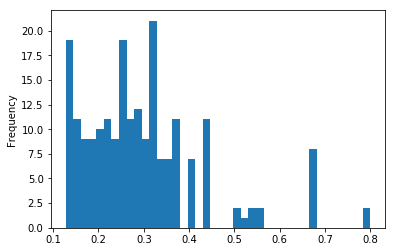

In [111]:
%matplotlib inline
(tanks_df['MainGunAP'] / tanks_df['Price']).plot.hist(bins=40)
import matplotlib.pyplot as plt
lims = plt.gca().get_xlim()

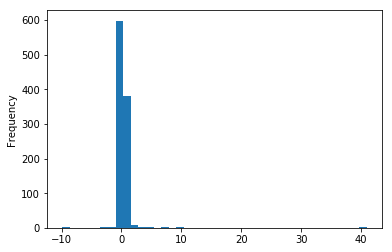

In [113]:
pd.DataFrame(model.sample(1000), columns=[c for c in tanks_df.columns if c != 'MainGunName'])\
    .pipe(lambda df: df['MainGunAP'] / df['Price']).plot.hist(bins=40)

(0.09416666666666665, 0.8336111111111113)

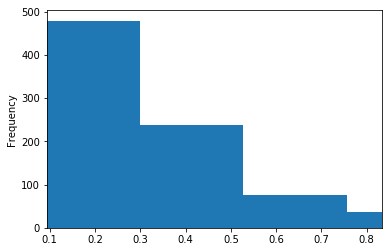

In [112]:
pd.DataFrame(model.sample(1000), columns=[c for c in tanks_df.columns if c != 'MainGunName'])\
    .pipe(lambda df: df['MainGunAP'] / df['Price']).plot.hist(bins=40)
plt.gca().set_xlim(lims)

Here I am testing the validity of the model by examining the distribution of AP to Price for samples drawn from it. This is an important learned relationship in W:RD, so it should be modeled very clearly. We see here that the model does capture the fundamental shape, but that it also experiences rare events which would never occur inside the game.

While it's encouraging that the *general shape* of this derived statistic looks realistic, these outliers are a problem. They occur because the KDE model doesn't assume anything about hard limits on the underlying data.

For example, domain knowledge tells us that AP is always between 1 and 24. But here in what the model outputs:

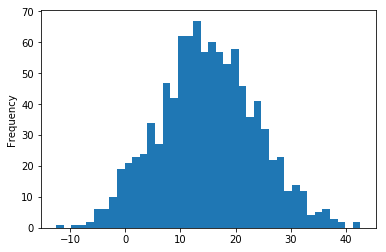

In [114]:
pd.DataFrame(model.sample(1000), columns=[c for c in tanks_df.columns if c != 'MainGunName']).MainGunAP.plot.hist(bins=40)

Compare this with reality:

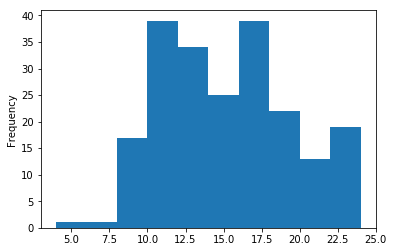

In [118]:
tanks_df.MainGunAP.plot.hist(bins=10)

Since the fundamental distribution looks good, we know that we can partially deal with this distributional problem by simply rejecting samples that are drawn that lie outside known boundaries. If we follow that procedure we get the following graph:

In [126]:
def conditional_sample(model, n, cond):
    samples = []
    while len(samples) < n:
        sample = model.sample(1)[0]
        sample = pd.Series(sample, index=[c for c in tanks_df.columns if c != 'MainGunName'])
        if cond(sample):
            samples.append(sample)
    return pd.DataFrame(samples)

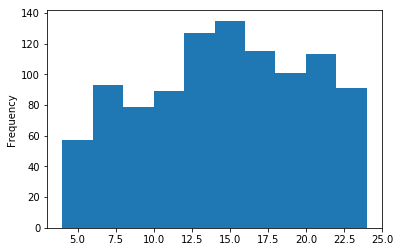

In [128]:
conditional_sample(model, 
                   1000, 
                   lambda sample: tanks_df.MainGunAP.min() < sample.MainGunAP < tanks_df.MainGunAP.max()
                  )\
    .MainGunAP.plot.hist()

Hmm, the distribution looks different. Perhaps normalization will improve things?

In [138]:
from sklearn.preprocessing import normalize
tanks_df_norm = pd.DataFrame(
    normalize(tanks_df.drop('MainGunName', axis='columns').assign(Amphibious=tanks_df.Amphibious.astype(int))),
    columns=tanks_df.drop('MainGunName', axis='columns').columns
)
tanks_df_norm

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import numpy as np

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(tanks_df_norm)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

model = grid.best_estimator_

best bandwidth: 0.1


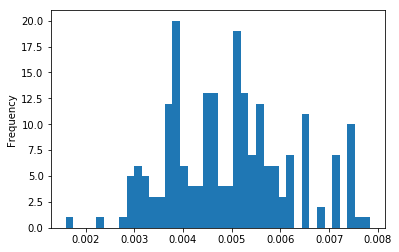

In [143]:
tanks_df_norm.MainGunAP.plot.hist(bins=40)

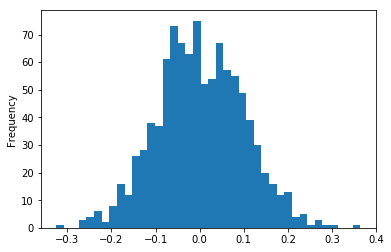

In [142]:
pd.DataFrame(model.sample(1000), columns=tanks_df.drop('MainGunName', axis='columns').columns).MainGunAP.plot.hist(bins=40)

Hmm. That doesn't correct the issue. And in fact, we start to see a big, and undesirable, jump in on how long it takes to generate samples (e.g. we are rejecting way more samples).

1.19 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


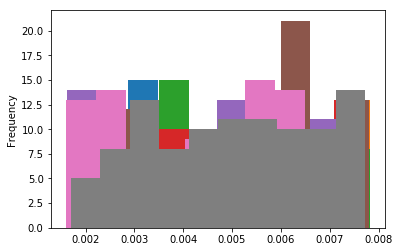

In [151]:
%timeit conditional_sample(model, 100, lambda sample: tanks_df_norm.MainGunAP.min() < sample.MainGunAP < tanks_df_norm.MainGunAP.max()).MainGunAP.plot.hist()

It seems like this approach doesn't work that well either! Given all this we should probably try some other algorithm, like linear regression, and see if that performs better.